In [1]:
import pandas as pd 
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

2025-06-28 19:51:08.410531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751140268.611662      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751140268.671212      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
ar_data4 = pd.read_csv("/kaggle/input/ar-data-train-tweet/ar_tweet_train/train_all.csv")

In [3]:
ar_data4["sentiment"].value_counts()

sentiment
neutral     37359
positive     8821
negative     8820
Name: count, dtype: int64

In [4]:
ar_data4 = ar_data4.drop("Tweet_id", axis=1)


In [5]:
neutral_samples = ar_data4[ar_data4["sentiment"] == "neutral"].sample(n=20000, random_state=42)
positive_samples = ar_data4[ar_data4["sentiment"] == "positive"].sample(n=8000, random_state=42)
negative_samples = ar_data4[ar_data4["sentiment"] == "negative"].sample(n=8000, random_state=42)


In [6]:
balanced_ar_train_data = pd.concat([neutral_samples, positive_samples, negative_samples], ignore_index=True)


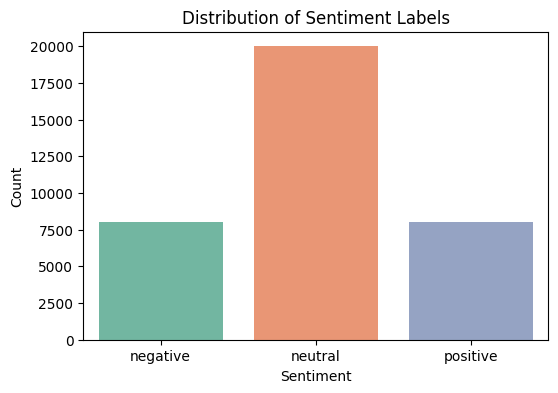

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(data=balanced_ar_train_data, x='sentiment', order=['negative', 'neutral', 'positive'], palette='Set2')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [8]:
balanced_ar_train_data = balanced_ar_train_data.rename(columns={"sentiment": "labels" })


In [9]:
balanced_ar_train_data

,labels,Text
0,neutral,@mhrsd_care السلام عليكم كيف اقدر اقدم بلاغ..؟
1,neutral,@MoweSa تم طلب تصريح تم رفض ذلك ماهي الأسباب. ...
2,neutral,اللهم إرحم من فارق دِيَارنا وأصبح القبر داره ...
3,neutral,قال علي رضي الله عنه للحسن : كن في الدنيا ببدن...
4,neutral,#حذف_امازون_وسوق_كوم انا مع. وطني ووطني مصرح ا...
...,...,...
35995,negative,#360_يوم_إنتهاكات تكميم افواه قمع حريات استبدا...
35996,negative,هاتو موضوع نسولف فيه غير كورونا .. ويلكم ملينا...
35997,negative,لا انا علي طول بعد الي يجعلني حزين
35998,negative,عندى كمية أسئلة ل نفسى و على نفسى و نفسى ف اجابة


# Test Data

In [10]:
ar_data3 = pd.read_csv("/kaggle/input/ar-tweets/Tweets.txt", sep="\t", header=None, names=["text", "labels"], encoding="utf-8")

In [11]:
ar_data2 = pd.read_csv("/kaggle/input/nlp-arabic-tweets-competition/train.csv")

In [12]:
ar_data2

,tweet,class
0,' #علمتني_الحياه أن الذين يعيشون على الأرض ليس...,pos
1,' #ميري_كرسمس كل سنة وانتم طيبين http://t.co/n...,pos
2,' و انتهى مشوار الخواجة ',neg
3,' مش عارف ابتدى مذاكره منين :/ ',neg
4,' @mskhafagi إختصروا الطريق بدلا من إختيار ال...,neg
...,...,...
2054,' @wasfa_N الجمال مبيحتاح اي مكياج لناعم وله خ...,neu
2055,' @TheMurexDor نتمني وجود الفنانة رنا سماحة اف...,neu
2056,' ولد الهدى فالكائنات ضياء .. وفم الزمان تبسم ...,pos
2057,' @mohamed71944156 @samarroshdy1 انت متناقض جد...,neg


In [13]:
ar_data2 = ar_data2.rename(columns={"class": "labels","tweet":"Text"})
ar_data3 = ar_data3.rename(columns={"labels": "labels","text":"Text"})


In [14]:
ar_data3["labels"].value_counts()

labels
OBJ        6470
NEG        1642
NEUTRAL     805
POS         777
Name: count, dtype: int64

In [15]:
neutral_samples_test = ar_data3[ar_data3["labels"] == "NEUTRAL"].sample(n=800, random_state=42)
positive_samples_test = ar_data3[ar_data3["labels"] == "POS"].sample(n=700, random_state=42)
negative_samples_test = ar_data3[ar_data3["labels"] == "NEG"].sample(n=700, random_state=42)

In [16]:
ar_data2["labels"].value_counts()

labels
pos    792
neg    677
neu    590
Name: count, dtype: int64

In [17]:
neutral_samples_test2 = ar_data2[ar_data2["labels"] == "neu"].sample(n=590, random_state=42)
positive_samples_test2 = ar_data2[ar_data2["labels"] == "pos"].sample(n=600, random_state=42)
negative_samples_test2 = ar_data2[ar_data2["labels"] == "neg"].sample(n=600, random_state=42)

In [18]:
balanced_ar_test_data = pd.concat([neutral_samples_test, positive_samples_test, negative_samples_test,neutral_samples_test2,positive_samples_test2,negative_samples_test2], ignore_index=True)


In [19]:
balanced_ar_test_data["labels"] = balanced_ar_test_data["labels"].replace({
    "POS": "positive", "pos": "positive",
    "NEG": "negative", "neg": "negative",
    "NEUTRAL": "neutral", "neu": "neutral"
})

In [20]:
balanced_ar_test_data["labels"].value_counts()

labels
neutral     1390
positive    1300
negative    1300
Name: count, dtype: int64

# EN_Data

In [21]:
en_data = pd.read_csv("/kaggle/input/en-tweets-sentiment/betsentiment-EN-tweets-sentiment-players.csv", encoding='ISO-8859-1')


In [22]:
en_data["sentiment"].value_counts()

sentiment
NEUTRAL     1309490
POSITIVE     499342
NEGATIVE     109858
MIXED         12646
Name: count, dtype: int64

In [23]:
samples_data=en_data[:200000].drop(["tweet_id","language" ,"sentiment_score","tweet_date_created"],axis=1)

In [24]:
samples_data

,tweet_text,sentiment
0,I vote @BernardoCSilva for @Budweiser #Manofth...,NEUTRAL
1,When is your first match? Didn't see you today...,NEUTRAL
2,@Cristiano You never know what you had till it...,NEUTRAL
3,@youngy18 @England You look good man I'd appre...,POSITIVE
4,@LFC @officialAL20 @IntChampionsCup @ManUtd Ex...,NEUTRAL
...,...,...
199995,@Spudfish83 If they are in the #WorldCup then ...,NEUTRAL
199996,@FrankYeboahk @SergioRamos @realmadrid Always ...,NEUTRAL
199997,".@LCFC's own @BenChilwell about to come on, as...",NEUTRAL
199998,@NickVann1987 @LeeGunner82 @cesc4official As m...,POSITIVE


In [25]:
samples_data["sentiment"].value_counts()

sentiment
NEUTRAL     135367
POSITIVE     51909
NEGATIVE     11392
MIXED         1332
Name: count, dtype: int64

In [26]:
en_neutral_samples = samples_data[samples_data["sentiment"] == "NEUTRAL"].sample(n=20000, random_state=42)
en_positive_samples = samples_data[samples_data["sentiment"] == "POSITIVE"].sample(n=8000, random_state=42)
en_negative_samples = samples_data[samples_data["sentiment"] == "NEGATIVE"].sample(n=8000, random_state=42)

In [27]:
balanced_en_train_data = pd.concat([en_neutral_samples, en_positive_samples, en_negative_samples], ignore_index=True)

In [28]:
balanced_en_train_data

,tweet_text,sentiment
0,@WayneRooney @ColeenRoo I wish you were showin...,NEUTRAL
1,@CraneJ3 @hashman88 @LukaszFabianski Man raise...,NEUTRAL
2,Who else but @kschmeichel1 for @Budweiser #Man...,NEUTRAL
3,This needs to be the new ozil song @MesutOzil1...,NEUTRAL
4,#Ramos_The_Animal am not surprised from your f...,NEUTRAL
...,...,...
35995,@NabilFekir Go and prove them wrong pal. Your ...,NEGATIVE
35996,@SergioRamos Terrible player on the face of th...,NEGATIVE
35997,The Liverpool anthem is you'll never walk alon...,NEGATIVE
35998,@England no creativity in the final third... h...,NEGATIVE


In [29]:
 balanced_en_train_data = balanced_en_train_data.rename(columns={"sentiment":"labels","tweet_text": "Text"})

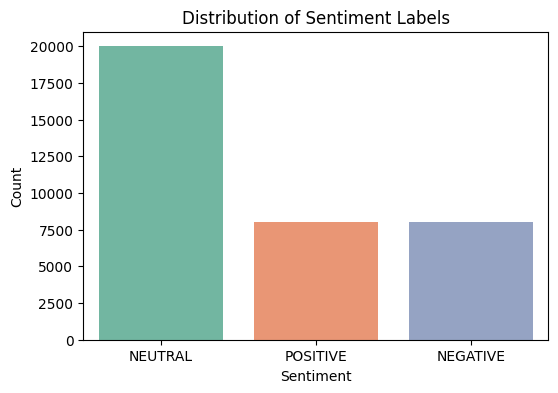

In [30]:
plt.figure(figsize=(6,4))
sns.countplot(data=balanced_en_train_data, x='labels', order=['NEUTRAL', 'POSITIVE', 'NEGATIVE'], palette='Set2')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# EN Test Data

In [31]:
samples_data_test=en_data[200000:300000].drop(["tweet_id","language" ,"sentiment_score","tweet_date_created"],axis=1)

In [32]:
samples_data_test = samples_data_test.rename(columns={"tweet_text": "Text","sentiment": "labels"})

In [33]:
samples_data_test

,Text,labels
200000,I vote @mzanka for @Budweiser #ManoftheMatch #...,NEUTRAL
200001,@markdokeefe @REHopkinson @Sio_Chamberlain @WO...,NEUTRAL
200002,@TimGossage @Tim_Cahill @ALeague Hey Ive hear...,NEUTRAL
200003,Who else but @simonkjaer1989 for @Budweiser #M...,NEUTRAL
200004,@SMignolet @axelwitsel28 @Fellaini @dries_mert...,NEUTRAL
...,...,...
299995,@RealistYahz @Rashford101 @AnthonyMartial I do...,NEUTRAL
299996,@ash_froment @TeamMessi @Cristiano Riley doesn...,NEUTRAL
299997,@willy_caballero whats the point of you even ...,NEUTRAL
299998,Uli Hoeness comments on @MesutOzil1088 retire...,NEUTRAL


In [34]:
samples_data_test["labels"].value_counts()

labels
NEUTRAL     67720
POSITIVE    25948
NEGATIVE     5669
MIXED         663
Name: count, dtype: int64

In [35]:
en_neutral_samples_test = samples_data_test[samples_data_test["labels"] == "NEUTRAL"].sample(n=1300, random_state=42)
en_positive_samples_test = samples_data_test[samples_data_test["labels"] == "POSITIVE"].sample(n=1300, random_state=42)
en_negative_samples_test = samples_data_test[samples_data_test["labels"] == "NEGATIVE"].sample(n=1300, random_state=42)

In [36]:
balanced_en_test_data = pd.concat([en_neutral_samples_test, en_positive_samples_test, en_negative_samples_test], ignore_index=True)

In [37]:
balanced_en_test_data["labels"].value_counts()

labels
NEUTRAL     1300
POSITIVE    1300
NEGATIVE    1300
Name: count, dtype: int64

=============================================================

In [38]:
df_train = pd.concat([balanced_ar_train_data, balanced_en_train_data], ignore_index=True)
df_test = pd.concat([balanced_ar_test_data, balanced_en_test_data], ignore_index=True)


In [39]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7890 entries, 0 to 7889
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    7890 non-null   object
 1   labels  7890 non-null   object
dtypes: object(2)
memory usage: 123.4+ KB


In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72000 entries, 0 to 71999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  72000 non-null  object
 1   Text    72000 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [41]:
 
df_train["labels"]= df_train["labels"].replace({
        "neutral"   : 1, 
        "positive"  : 2,
        "negative"  : 0,
        "NEUTRAL"   : 1,
        "POSITIVE"  : 2,
        "NEGATIVE"  : 0,
})


/tmp/ipykernel_19/1986837530.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train["labels"]= df_train["labels"].replace({


In [42]:
df_test["labels"]= df_test["labels"].replace({
       "neutral"   : 1, 
        "positive"  : 2,
        "negative"  : 0,
        "NEUTRAL"   : 1,
        "POSITIVE"  : 2,
        "NEGATIVE"  : 0,
})

/tmp/ipykernel_19/4004229202.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test["labels"]= df_test["labels"].replace({


In [43]:
df_train["labels"] = df_train["labels"].astype(int)
df_test["labels"] = df_test["labels"].astype(int)

In [44]:
df_test

,Text,labels
0,#ذات_مومنت لما تقدم عرض عمل جديد متحمسله عمرك ...,1
1,و الله تستاهل ياقلبي ليه تميل مكنت خالي انت اس...,1
2,حركة تمرد صاحبة انتصار 30 يونيو طالبت بالبرادع...,1
3,الغاء الاعلان الدستورى المكمل الذى كنا ضده منذ...,1
4,انا محنيش جبيني غير لرب الخلق ، ولا بالحرق ولا...,1
...,...,...
7885,@SergioRamos You are just a dirty player alway...,0
7886,@5liveSport @IanWright0 @sterling7 Complete ru...,0
7887,@EssexLFC1 @MrDtAFC @MatteoGuendouzi 80% pass ...,0
7888,@fifacom_es @Cristiano @lukamodric10 @MoSalah ...,0


In [45]:
# train_dataset = Dataset.from_pandas(df_train)
# test_dataset = Dataset.from_pandas(df_test)

 

In [46]:
df_train

,labels,Text
0,1,@mhrsd_care السلام عليكم كيف اقدر اقدم بلاغ..؟
1,1,@MoweSa تم طلب تصريح تم رفض ذلك ماهي الأسباب. ...
2,1,اللهم إرحم من فارق دِيَارنا وأصبح القبر داره ...
3,1,قال علي رضي الله عنه للحسن : كن في الدنيا ببدن...
4,1,#حذف_امازون_وسوق_كوم انا مع. وطني ووطني مصرح ا...
...,...,...
71995,0,@NabilFekir Go and prove them wrong pal. Your ...
71996,0,@SergioRamos Terrible player on the face of th...
71997,0,The Liverpool anthem is you'll never walk alon...
71998,0,@England no creativity in the final third... h...


In [47]:
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [48]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.texts = dataframe["Text"].tolist()
        self.labels = dataframe["labels"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [49]:
from torch.utils.data import DataLoader
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual")

train_df, val_df = train_test_split(df_train, test_size=0.1, random_state=42, stratify=df_train["labels"])

train_dataset = SentimentDataset(train_df, tokenizer)
val_dataset = SentimentDataset(val_df, tokenizer)
test_dataset = SentimentDataset(df_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [50]:
from torch.optim import AdamW
from tqdm import tqdm
import torch
from transformers import get_scheduler

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


optimizer = AdamW(model.parameters(), lr=3e-5)
epochs = 7
num_training_steps = epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)



config.json:   0%|          | 0.00/982 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [51]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(loss=loss.item())



Epoch [7/7]: 100%|██████████| 4050/4050 [28:40<00:00,  2.35it/s, loss=0.00218]


In [52]:
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch["labels"].cpu().numpy())

    print(f"\nValidation Report for Epoch {epoch+1}:")
    print(classification_report(val_labels, val_preds, target_names=["Negative", "Neutral", "Positive"]))



Validation Report for Epoch 7:
              precision    recall  f1-score   support

    Negative       0.76      0.78      0.77      1600
     Neutral       0.85      0.84      0.85      4000
    Positive       0.81      0.81      0.81      1600

    accuracy                           0.82      7200
   macro avg       0.81      0.81      0.81      7200
weighted avg       0.82      0.82      0.82      7200



In [53]:
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(batch["labels"].cpu().numpy())

print("\nFinal Test Report:")
print(classification_report(test_labels, test_preds, target_names=["Negative", "Neutral", "Positive"]))



Final Test Report:
              precision    recall  f1-score   support

    Negative       0.79      0.63      0.70      2600
     Neutral       0.53      0.81      0.64      2690
    Positive       0.85      0.55      0.67      2600

    accuracy                           0.67      7890
   macro avg       0.72      0.66      0.67      7890
weighted avg       0.72      0.67      0.67      7890



##############

In [54]:
# 1. تحميل الموديل والتوكنيزر
second_model_name = "xlm-roberta-base"
tokenizer2 = AutoTokenizer.from_pretrained(second_model_name)
model2 = AutoModelForSequenceClassification.from_pretrained(second_model_name, num_labels=3).to(device)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
 
# 2. إعادة إنشاء Dataset وDataLoader بنفس الطريقة
train_ds2 = SentimentDataset(train_df, tokenizer2)
val_ds2   = SentimentDataset(val_df, tokenizer2)
test_ds2  = SentimentDataset(pd.concat([val_df, pd.DataFrame(df_test)], ignore_index=True), tokenizer2)

train_loader2 = DataLoader(train_ds2, batch_size=16, shuffle=True)
val_loader2   = DataLoader(val_ds2, batch_size=32)
test_loader2  = DataLoader(test_ds2, batch_size=32)


In [56]:
# 3. إعادة تهيئة optimizer وscheduler
optimizer2 = AdamW(model2.parameters(), lr=3e-5)
num_train_steps2 = epochs * len(train_loader2)
scheduler2 = get_scheduler("linear", optimizer=optimizer2, num_warmup_steps=0, num_training_steps=num_train_steps2)


In [57]:
 
 
# 4. حلقة التدريب للنموذج الثاني
for epoch in range(epochs):
    model2.train()
    for batch in tqdm(train_loader2, desc=f"XLM-R Train Epoch {epoch+1}"):
        b = {k: v.to(device) for k, v in batch.items()}
        outputs = model2(**b)
        outputs.loss.backward()
        optimizer2.step()
        scheduler2.step()
        optimizer2.zero_grad()

 
 

XLM-R Train Epoch 7: 100%|██████████| 4050/4050 [28:26<00:00,  2.37it/s]


In [58]:
    # تقييم validation
    model2.eval()
    preds2, labs2 = [], []
    with torch.no_grad():
        for batch in val_loader2:
            b = {k: v.to(device) for k, v in batch.items()}
            logits = model2(**b).logits
            preds2.extend(torch.argmax(logits, dim=1).cpu().numpy())
            labs2.extend(b["labels"].cpu().numpy())

    print(f"Validation Report XLM-R Epoch {epoch+1}:")
    print(classification_report(labs2, preds2, target_names=["Negative","Neutral","Positive"]))


Validation Report XLM-R Epoch 7:
              precision    recall  f1-score   support

    Negative       0.72      0.78      0.75      1600
     Neutral       0.86      0.81      0.83      4000
    Positive       0.77      0.83      0.80      1600

    accuracy                           0.81      7200
   macro avg       0.78      0.80      0.79      7200
weighted avg       0.81      0.81      0.81      7200



In [59]:
# 5. تقييم على test
model2.eval()
test_preds2, test_labs2 = [], []
with torch.no_grad():
    for batch in test_loader2:
        b = {k: v.to(device) for k, v in batch.items()}
        logits = model2(**b).logits
        test_preds2.extend(torch.argmax(logits, dim=1).cpu().numpy())
        test_labs2.extend(b["labels"].cpu().numpy())

print("\nFinal Test Report Second Model (XLM-Roberta):")
print(classification_report(test_labs2, test_preds2, target_names=["Negative","Neutral","Positive"]))



Final Test Report Second Model (XLM-Roberta):
              precision    recall  f1-score   support

    Negative       0.74      0.70      0.72      4200
     Neutral       0.69      0.79      0.74      6690
    Positive       0.80      0.66      0.72      4200

    accuracy                           0.73     15090
   macro avg       0.74      0.72      0.73     15090
weighted avg       0.74      0.73      0.73     15090



In [60]:
model.save_pretrained("models/first_model")
tokenizer.save_pretrained("models/first_model")


('models/first_model/tokenizer_config.json',
 'models/first_model/special_tokens_map.json',
 'models/first_model/sentencepiece.bpe.model',
 'models/first_model/added_tokens.json',
 'models/first_model/tokenizer.json')

In [61]:
model2.save_pretrained("models/xlmr_model")
tokenizer2.save_pretrained("models/xlmr_model")

('models/xlmr_model/tokenizer_config.json',
 'models/xlmr_model/special_tokens_map.json',
 'models/xlmr_model/sentencepiece.bpe.model',
 'models/xlmr_model/added_tokens.json',
 'models/xlmr_model/tokenizer.json')